# Worksheet 22

Name:  
UID: 

### Topics

- Confidence Intervals
- Checking Assumptions

### Confidence Intervals

From worksheet 18, we know that, provided the assumptions from linear regression hold:

$$\hat\beta \sim \mathcal{N}(\beta,\sigma^2 (X^TX)^{-1})$$

thus for each component $k$ of $\hat\beta$

$$\hat\beta_k \sim \mathcal{N}(\beta_k, \sigma^2 S_{kk})$$

where $S_{kk}$ is the $k^\text{th}$ diagonal element of $(X^TX)^{-1}$. 

While we know that the estimate of beta is an unbiased estimator, we don't know the standard deviation. So in practice we use an unbiased estimate of the standard deviation instead. This estimate is the standard error `s`

$$s = \sqrt{\frac{RSS}{n - p}}$$

where p is the number of parameters beta (the intercept counts as one such parameter). This normalized $\hat\beta$ can be shown to follow a t-distribution with `n-p` degrees of freedom. Below we can see this is the case through a simulation:

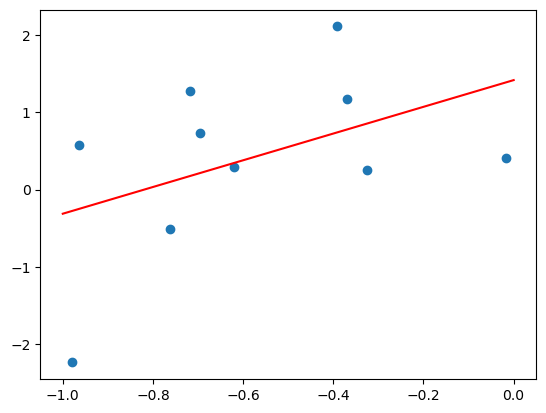

In [16]:
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

SAMPLE_SIZE = 10

x = -1.0 + 1.0 * np.random.random(SAMPLE_SIZE)
y = 0.0 * x + np.random.randn(SAMPLE_SIZE)
intercept = np.ones(np.shape(x)[0])
X = np.array([intercept, x]).T
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
xs = np.linspace(-1, 0, 100)


plt.scatter(x, y)
plt.plot(xs, beta_hat[0] + beta_hat[1] * xs, c='r')
plt.show()

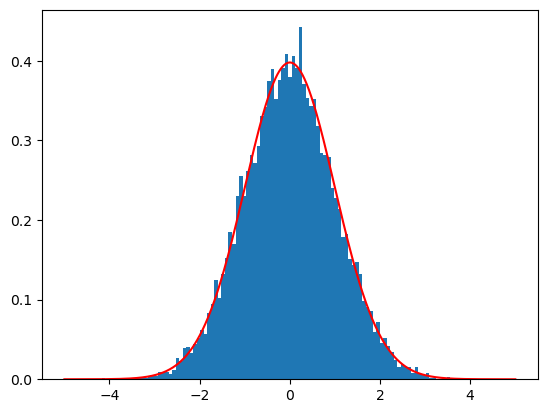

In [17]:
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

def standard_error(ytrue, ypred):
    return (sum((ytrue - ypred)**2) / (len(ytrue) - 2)) ** (1/2)

def normalized(beta, mu, sig, skk):
    return (beta - mu) / (((sig ** 2) * skk) ** (1/2))

SAMPLE_SIZE = 100
TRIALS = 10000

beta_hist = []
for _ in range(TRIALS):
    x = -1.0 + 1.0 * np.random.random(SAMPLE_SIZE)
    y = 0.0 * x + np.random.randn(SAMPLE_SIZE)
    intercept = np.ones(np.shape(x)[0])
    X = np.array([intercept, x]).T
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    skk = np.linalg.inv(X.T @ X)[1][1]
    s = standard_error(y, X @ beta)
    beta_hist.append(normalized(beta[1], 0, s, skk))

xs = np.linspace(-5,5,1000)
fig, ax = plt.subplots()
ax.hist(beta_hist, bins=100, density=True)
ax.plot(xs, t.pdf(xs, SAMPLE_SIZE - 2), color='red')
plt.show()

The probability that normalized $\hat\beta$ is less than 0 can be found by evaluating the CDF of the t-distribution above. This clearly evaluates to .5.

a) What is the probability that normalized $\hat\beta$ is less than -2?

In [18]:
print(t.cdf(0, SAMPLE_SIZE -2))

0.5


b) Still assuming that there is no relationship between X and Y. What value would the normalized $\hat\beta$ only be less than ~1% of the time? Another way to phrase this is: what value would the normalized $\hat\beta$ be greater than 99% of the time? i.e.

$$\int_{-\infty}^{x} t_{pdf}(t)dt = .01 $$

In [19]:
from scipy.stats import norm

def search(alpha, df):
    d = 4
    epsilon = .001
    delta = 1 * 10 ** (-d)
    i = -5
    while i < 5:
        i += epsilon
        val = t.cdf(i, df)
        if abs(alpha - val) < delta:
            return round(i, ndigits=d-2)
    ValueError("couldn't find anything")

t_alpha = search(.01, SAMPLE_SIZE - 2)
print(t_alpha)
print(t.cdf(t_alpha, SAMPLE_SIZE - 2))

-2.37
0.009873264817099586


c) What value of $\hat\beta$ does the above translate to? i.e. what value would $\hat\beta$ only be less than 1% of the time (assuming there is no relationship between X and Y)?

In [20]:
skk = np.linalg.inv(X.T @ X)[1][1]
s = standard_error(y, X @ beta)
t_alpha = search(.01, SAMPLE_SIZE - 2)
beta_hat = t_alpha * ((s ** 2) * skk) ** (1/2)

print(t_alpha)
print(beta_hat)
print(t.cdf(normalized(beta_hat, 0, s, skk), SAMPLE_SIZE - 2))

-2.37
-0.808729179771596
0.009873264817099586


d) So what range of values [-t, t] is expected to hold $\hat\beta$ ~98% of the time?

[-.788, .788]

e) Verify this by running a simulation where you fix the interval and record the number of times in a given number of TRIALS that $\hat\beta$ falls in the interval.

In [21]:
interval_min = -.788
interval_max = .788

TRIALS = 10000
SAMPLE_SIZE = 100

count = 0
for _ in range(TRIALS):
    x = -1.0 + 1.0 * np.random.random(SAMPLE_SIZE)
    y = 0.0 * x + np.random.randn(SAMPLE_SIZE)
    intercept = np.ones(np.shape(x)[0])
    X = np.array([intercept, x]).T
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    if beta[1] > interval_min and beta[1] < interval_max :
        count += 1

print(count / TRIALS)

0.9792


f) For the dataset below, report the 99% confidence interval around the estimate of the slope

In [22]:
x = np.array([-0.1920605, -0.11290798, -0.56434374, -0.67052057, -0.19233284, -0.42403586, -0.8114285, -0.38986946, -0.37384161, -0.50930229])
y = np.array([-0.34063108, -0.33409286, 0.34245857, 0.11062295, 0.76682389, 0.86592388, -1.68912015, -2.01463592, 1.61798563, 0.60557414])

intercept = np.ones(np.shape(x)[0])
X = np.array([intercept, x]).T
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
print(beta_hat)

skk = np.linalg.inv(X.T @ X)[1][1]
s = standard_error(y, X @ beta)
t_alpha = search(.2, len(x) - 2)

print("60% CI around the slope is: [", beta_hat[1] + t_alpha * ((s ** 2) * skk) ** (1/2) , ", ", beta_hat[1] - t_alpha * ((s ** 2) * skk) ** (1/2) ,"]")


[0.50155603 1.19902827]
60% CI around the slope is: [ -0.36573795208756743 ,  2.763794496068808 ]


g) Based on this confidence interval, what can you deduce about the relationship between x and y?

Since the confidence interval also contains 0, I can deduce that the relationship between x and y are rather insignificant.

### Checking Assumptions

The 50% quantile of $\mathcal{N}(0, \sigma^2)$ is 0 because 50% of the values are below 0.

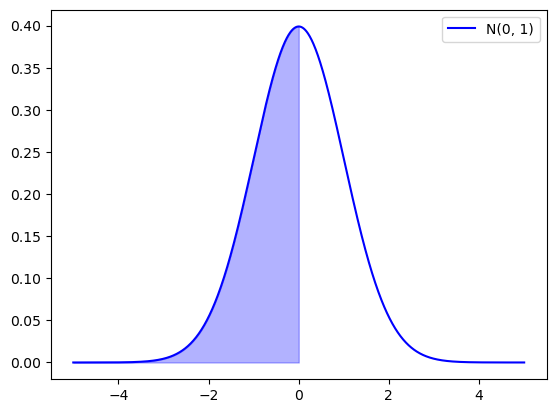

In [23]:
from scipy.stats import norm

xs = np.linspace(-5,5,1000)
xs_upto = np.linspace(-5,0,1000)
fig, ax = plt.subplots()
ax.plot(xs, norm.pdf(xs, 0, 1), color='blue', label='N(0, 1)')
ax.fill_between(xs_upto, norm.pdf(xs_upto, 0, 1), color='blue', alpha=0.3)
ax.legend()
plt.show()


a) What is the 25% quantile of the $\mathcal{N}(0, 1)$?

In [24]:
def theoretical_quantile(q, mu, sigma):
    d = 3
    epsilon = .001
    delta = 1 * 10 ** (-d)
    i = -5
    while i < 5:
        i += epsilon
        val = norm.cdf(i, mu, sigma)
        if abs(q - val) < delta:
            return round(i, ndigits=d-1)
    ValueError("couldn't find anything")

print(theoretical_quantile(.25, 0, 1))

-0.68


b) What is the 25% quantile of the following sample from a $\mathcal{N}(0, 1)$?

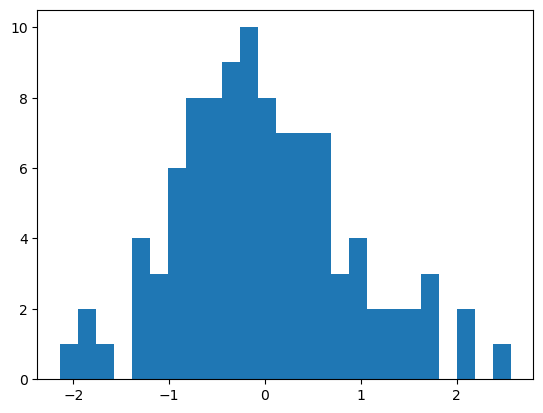

-0.14490114094562812


In [25]:
SAMPLE_SIZE = 100

sample = norm.rvs(0, 1, size=SAMPLE_SIZE)

fig, ax = plt.subplots()
ax.hist(sample, bins=25)
plt.show()

def sample_quantile(q, sample):
    sorted_sample = np.sort(sample)
    count = 0
    for i in range(len(sorted_sample)):
        count += 1
        if count / len(sample) >= q :
            return sorted_sample[i]
    raise ValueError("unable to find quantile")

print(sample_quantile(.5, sample))

c) Create a scatter plot where the x axis has the theoretical quantiles from the normal distribution and the y axis has the sample quantiles from the data above. You can plot every tenth quantile to keep things simple.

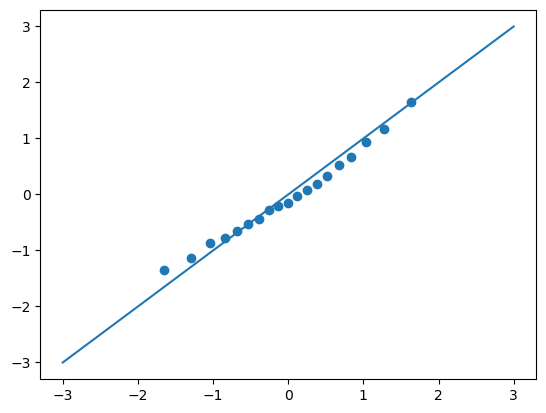

In [26]:
NUM_QUANT = 20
quants = [x / NUM_QUANT for x in range(1, NUM_QUANT)]

theory_quants = [theoretical_quantile(x, 0, 1) for x in quants]
sample_quants = [sample_quantile(x, sample) for x in quants]

xs = np.linspace(-3,3,1000)
fig, ax = plt.subplots()
ax.scatter(theory_quants, sample_quants)
ax.plot(xs, xs)
plt.show()

Recall, in linear regression we assume that $Y = X\beta + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma^2)$. $\epsilon = Y - X\beta$ but we can't just plot $\epsilon$ values to see if they follow a normal distribution because we don't know the true $\beta$ with which to multiply the X's in our dataset... Luckily, since $\hat\beta$ is an unbiased estimator of $\beta$ we can use $e = Y - X\hat\beta$ instead. These are called residuals and are estimates of $\epsilon$.

d) Describe how you would check that the normality assumption holds in the dataset you were given?

To check if our assumptions about how things are related are okay, we look at the differences between our predictions and what actually happened. These differences, called residuals, give us an idea about how accurate our predictions are. We want these residuals to follow a normal (bell-shaped) pattern. A perfect bell curve isn't usual, so a curve that is follows a bell is good.

Another, maybe more subtle assumption, is that the variance of the errors is constant (i.e. it does not depend on the value of X). Below are examples of datasets generated with and without constant variance.

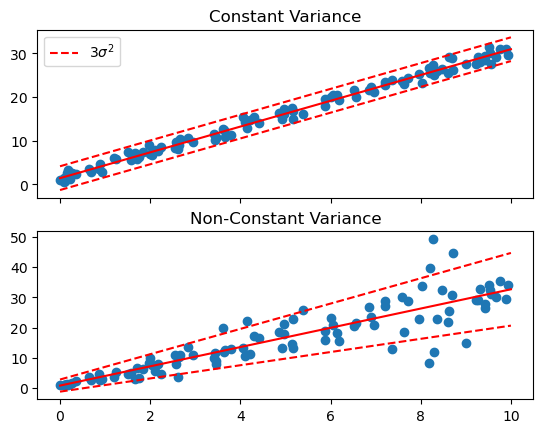

In [27]:
x = 0 + 10.0 * np.random.random(SAMPLE_SIZE)
y = 1 + 3 * x + np.random.randn(SAMPLE_SIZE)
intercept = np.ones(np.shape(x)[0])
X = np.array([intercept, x]).T
beta = np.linalg.inv(X.T @ X) @ X.T @ y
s = standard_error(y, X @ beta)

xs = np.linspace(0,10,1000)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.scatter(x, y)
ax1.plot(xs, beta[0] + beta[1] * xs, color='red')
ax1.plot(xs, 3 * s ** 2 + beta[0] + beta[1] * xs, c='r', linestyle='dashed', label='$3\sigma^2$')
ax1.plot(xs, - 3 * s ** 2 + beta[0] + beta[1] * xs, c='r', linestyle='dashed')
ax1.set_title("Constant Variance")
ax1.legend()

y1 = 1 + 3 * x + x * np.random.randn(SAMPLE_SIZE)
intercept = np.ones(np.shape(x)[0])
X = np.array([intercept, x]).T
beta1 = np.linalg.inv(X.T @ X) @ X.T @ y1
s = standard_error(y1, X @ beta1)

space = 2
ax2.scatter(x, y1)
ax2.plot(xs, beta1[0] + beta1[1] * xs, color='red')
ax2.plot(xs, space + xs + beta1[0] + beta1[1] * xs, c='r', linestyle='dashed')
ax2.plot(xs, - space - xs + beta1[0] + beta1[1] * xs, c='r', linestyle='dashed')
ax2.set_title("Non-Constant Variance")

plt.show()

While we can easily inspect these plots to check for constant variance, this is only because we have 2-dimensional data that we can actually visualize. In practice, there may be any number of features / explanatory variables so we need a different way to check this assumption. Recall the residuals should follow a normal distribution with constant variance. These residuals are always 1-dimensional since $e = Y - X \hat \beta$. But we can't plot wrt X since X is multi-dimensional. So the next best thing is to plot wrt $X \hat \beta$.

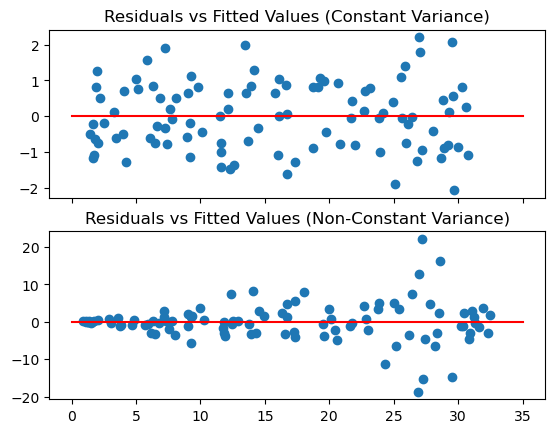

In [28]:
xs = np.linspace(0, 35,1000)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.scatter(X @ beta, y - X @ beta)
ax1.plot(xs, np.zeros_like(xs), color='red')
ax1.set_title("Residuals vs Fitted Values (Constant Variance)")

ax2.scatter(X @ beta1, y1 - X @ beta1)
ax2.plot(xs, np.zeros_like(xs), c='r')
ax2.set_title("Residuals vs Fitted Values (Non-Constant Variance)")
plt.show()

Non-constant variance is bad because it means the uncertainty of our prediction depends on what we are trying to predict. For example above if x is close to 0 then we will be closer to the true y than if x is closer to say 10.

If we run into non-constant variance in practice, we may be able to transform Y to lessen the 

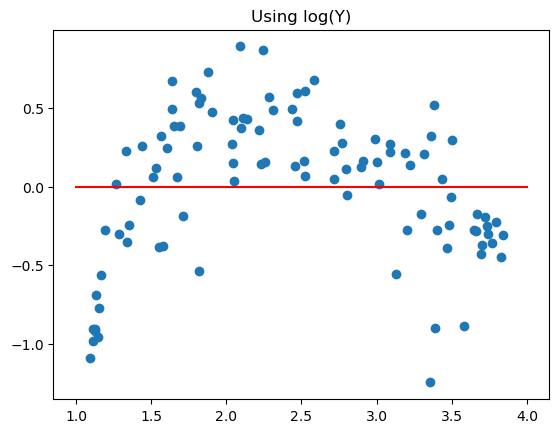

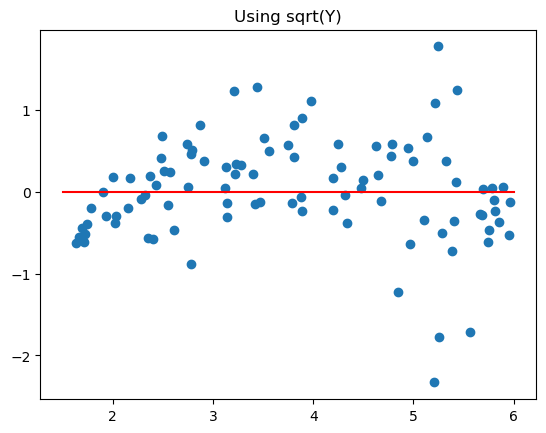

In [29]:
xs = np.linspace(1, 4, 1000)
fig, ax = plt.subplots()
new_beta = np.linalg.inv(X.T @ X) @ X.T @ np.log(y1)
ax.scatter(X @ new_beta, np.log(y1) - X @ new_beta)
ax.plot(xs, np.zeros_like(xs), c='r')
ax.set_title("Using log(Y)")
plt.show()

xs = np.linspace(1.5, 6, 1000)
fig, ax = plt.subplots()
new_beta = np.linalg.inv(X.T @ X) @ X.T @ np.sqrt(y1)
ax.scatter(X @ new_beta, np.sqrt(y1) - X @ new_beta)
ax.plot(xs, np.zeros_like(xs), c='r')
ax.set_title("Using sqrt(Y)")
plt.show()


### Generalized Linear Models

What happens when the errors are not normally distributed? This is the topic of GLM.

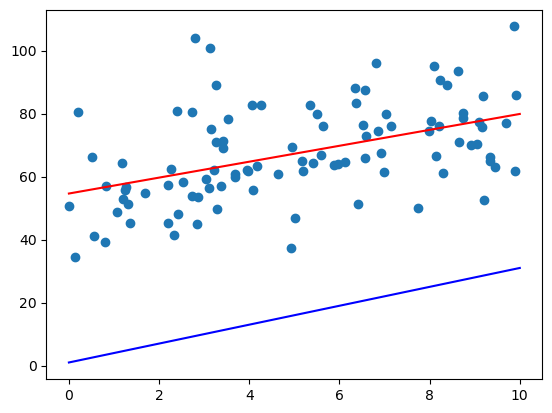

In [30]:
import numpy as np
import matplotlib.pyplot as plt

SAMPLE_SIZE = 100
x = 0 + 10.0 * np.random.random(SAMPLE_SIZE)
y = 1 + 3 * x + np.random.gamma(10, 5, SAMPLE_SIZE)
intercept = np.ones(np.shape(x)[0])
X = np.array([intercept, x]).T
beta = np.linalg.inv(X.T @ X) @ X.T @ y

xs = np.linspace(0,10,1000)
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(xs, beta[0] + beta[1] * xs, color='red') # learned line
ax.plot(xs, 1 + 3 * xs, c='b') # true line
plt.show()
